# Семинар 4: Линейная регрессия, временные признаки и регуляризация

## Подготовка и загрузка данных


In [ ]:
!pip install tsfresh

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [5]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [6]:
DATA_PATH = "./jena_climate_2009_2016.csv"

In [11]:
columns = ["Date Time", "p (mbar)",
               "T (degC)", "Tpot (K)",
               "Tdew (degC)", "rh (%)",
               "VPmax (mbar)", "VPact (mbar)",
               "VPdef (mbar)", "sh (g/kg)",
               "H2OC (mmol/mol)", "rho (g/m**3)",
               "wv (m/s)", "max. wv (m/s)", "wd (deg)"]

In [7]:
def load_jena(path: str) -> pd.DataFrame:
    """
    Пытается загрузить датасет Jena Climate из CSV.
    """
    columns = ["Date Time", "p (mbar)",
               "T (degC)", "Tpot (K)",
               "Tdew (degC)", "rh (%)",
               "VPmax (mbar)", "VPact (mbar)",
               "VPdef (mbar)", "sh (g/kg)",
               "H2OC (mmol/mol)", "rho (g/m**3)",
               "wv (m/s)", "max. wv (m/s)", "wd (deg)"]
    
    if os.path.exists(path):
        df = pd.read_csv(path)
        # Убедимся, что все ожидаемые столбцы присутствуют
        missing_cols = [c for c in columns if c not in df.columns]
        if missing_cols:
            raise ValueError(f"В файле отсутствуют ожидаемые столбцы: {missing_cols}")

    # Преобразование времени и индекса
    df["Date Time"] = pd.to_datetime(df["Date Time"], format='%d.%m.%Y %H:%M:%S')
    # df["Date Time"] = pd.to_datetime(df["Date Time"])
    df = df.sort_values("Date Time").set_index("Date Time")
    # df = df.sort_values("Date Time")
    return df

In [8]:
df = load_jena(DATA_PATH)
dfh = df.resample("1h").mean().dropna()
print("Форма:", df.shape, "| Часовые средние:", dfh.shape)

Форма: (420551, 14) | Часовые средние: (70041, 14)


In [9]:
corr = np.corrcoef(df.values, rowvar=False)

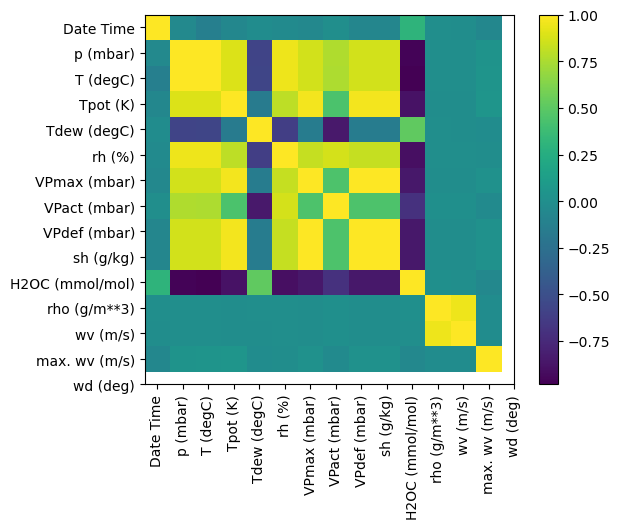

In [18]:
plt.imshow(corr)
_ = plt.xticks(ticks = np.arange(len(columns)), labels=columns, rotation=90)
_ = plt.yticks(ticks = np.arange(len(columns)), labels=columns)
plt.colorbar()

## Этап 1. OLS с нормированием, базовые метрики


In [51]:
from sklearn.model_selection import train_test_split

In [41]:
target = "T (degC)"
excluded = ["Date Time", "p (mbar)",
               "T (degC)", "Tpot (K)",
               "Tdew (degC)"]
features = [c for c in dfh.columns if (c not in excluded)]

In [59]:
d1 = dfh.index[0]

In [61]:
d1.date()

datetime.date(2009, 1, 1)

In [62]:
dates = [d.date() for d in dfh.index]

In [65]:
unique_dates = np.unique(dates)

In [66]:
dates_train, dates_test = train_test_split(unique_dates, test_size=0.7)

In [69]:
dfh_train = dfh[dfh.index.isin(dates_train)]

/tmp/ipykernel_3225/3716386312.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  dfh_train = dfh[dfh.index.isin(dates_train)]


In [70]:
dfh_test = dfh[dfh.index.isin(dates_test)]

/tmp/ipykernel_3225/402194335.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  dfh_test = dfh[dfh.index.isin(dates_test)]


In [71]:
X_train, X_test = dfh_train[features], dfh_test[features]
y_train, y_test = dfh_train[target], dfh_test[target]

In [76]:
features

['rh (%)',
 'VPmax (mbar)',
 'VPact (mbar)',
 'VPdef (mbar)',
 'sh (g/kg)',
 'H2OC (mmol/mol)',
 'rho (g/m**3)',
 'wv (m/s)',
 'max. wv (m/s)',
 'wd (deg)']

In [72]:
ols_pipe = Pipeline([("scaler", StandardScaler()), ("lr", LinearRegression())])
ols_pipe.fit(X_train, y_train)
y_pred_test = ols_pipe.predict(X_test)
y_pred_train = ols_pipe.predict(X_train)

In [54]:
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = root_mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print(f"OLS (normed) train: MAE={mae_test:.3f} | RMSE={rmse_test:.3f} | R²={r2_test:.3f}")
print(f"OLS (normed)  test: MAE={mae_train:.3f} | RMSE={rmse_train:.3f} | R²={r2_train:.3f}")

OLS (normed) train: MAE=0.437 | RMSE=0.610 | R²=0.995
OLS (normed)  test: MAE=0.436 | RMSE=0.607 | R²=0.995


In [73]:
# correct (daily) train-test split

mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = root_mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print(f"OLS (normed) train: MAE={mae_test:.3f} | RMSE={rmse_test:.3f} | R²={r2_test:.3f}")
print(f"OLS (normed)  test: MAE={mae_train:.3f} | RMSE={rmse_train:.3f} | R²={r2_train:.3f}")

OLS (normed) train: MAE=0.403 | RMSE=0.569 | R²=0.994
OLS (normed)  test: MAE=0.418 | RMSE=0.557 | R²=0.994


Text(0, 0.5, 'approximation')

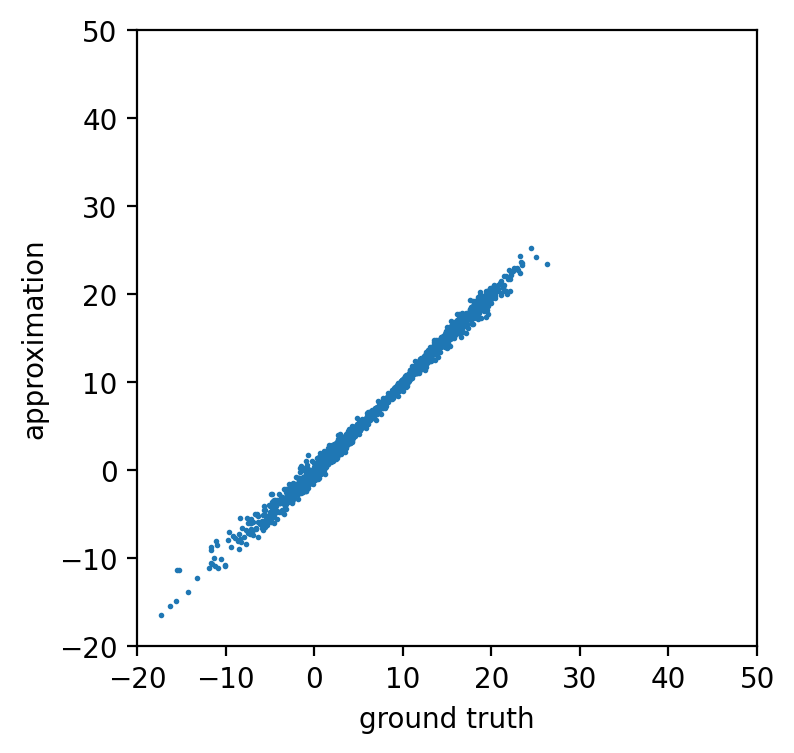

In [75]:
f = plt.figure(figsize=(4,4), dpi=200)
plt.scatter(y_test, y_pred_test, s=1)
# plt.axis("equal")
plt.xlim(-20, 50)
plt.ylim(-20, 50)

plt.xlabel('ground truth')
plt.ylabel('approximation')

## Этап 2. Кросс-валидация по времени (TimeSeriesSplit) для OLS


In [21]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

In [22]:
tscv = TimeSeriesSplit(n_splits=5)
# Отрицательная MSE (чем ближе к 0 — тем лучше), и R² (чем выше — тем лучше)
cv_mse = cross_val_score(ols_pipe, X_train, y_train, cv=tscv, scoring="neg_mean_squared_error")
cv_r2  = cross_val_score(ols_pipe, X_train, y_train, cv=tscv, scoring="r2")

In [24]:
print("CV OLS (train):")
print("  RMSE по подвыборкам:", np.sqrt(-cv_mse))
print("  R² по подвыборкам:  ", cv_r2)
print("  Средний RMSE:", np.sqrt(-cv_mse).mean(), " | Средний R²:", cv_r2.mean())

CV OLS (train):
  RMSE по подвыборкам: [0.01038592 0.00921204 0.01042172 0.0078217  0.00823012]
  R² по подвыборкам:   [0.99999871 0.999999   0.99999865 0.99999922 0.99999869]
  Средний RMSE: 0.009214297208341254  | Средний R²: 0.9999988547080495


## Этап 3. Временные признаки + OLS с нормированием


In [ ]:
work = dfh.copy()
for lag in [1,2,6,12,24]:
    work[f"T_lag{lag}"] = work["T (degC)"].shift(lag)
    if "rh (%)" in work.columns:
        work[f"rh_lag{lag}"] = work["rh (%)"].shift(lag)
    if "p (mbar)" in work.columns:
        work[f"p_lag{lag}"] = work["p (mbar)"].shift(lag)

work["T_roll6_mean"]  = work["T (degC)"].rolling(6,  min_periods=3).mean()
work["T_roll6_std"]   = work["T (degC)"].rolling(6,  min_periods=3).std()
work["T_roll24_mean"] = work["T (degC)"].rolling(24, min_periods=12).mean()

base_feats = [c for c in dfh.columns if c != "T (degC)"]
lag_feats  = [c for c in work.columns if ("lag" in c or "roll" in c)]
all_feats  = base_feats + lag_feats

work2 = work.dropna().copy()
X2 = work2[all_feats].values
y2 = work2["T (degC)"].values

split_idx2 = int(len(work2) * 0.7)
X2_train, X2_test = X2[:split_idx2], X2[split_idx2:]
y2_train, y2_test = y2[:split_idx2], y2[split_idx2:]

ols_lags_pipe = Pipeline([("scaler", StandardScaler()), ("ols", LinearRegression())])
ols_lags_pipe.fit(X2_train, y2_train)
y2_pred = ols_lags_pipe.predict(X2_test)

mae2 = mean_absolute_error(y2_test, y2_pred)
rmse2 = mean_squared_error(y2_test, y2_pred, squared=False)
r2_2 = r2_score(y2_test, y2_pred)
print(f"OLS (lags+roll, normed) — MAE={mae2:.3f} | RMSE={rmse2:.3f} | R²={r2_2:.3f}")


## Этап 4. Регуляризация: подбор `alpha` для Ridge и Lasso (GridSearchCV + TimeSeriesSplit)


In [ ]:
param_grid_ridge = {"ridge__alpha": np.logspace(-3, 3, 13)}
param_grid_lasso = {"lasso__alpha": np.logspace(-4, 1, 13)}

ridge_pipe = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(random_state=42))])
lasso_pipe = Pipeline([("scaler", StandardScaler()), ("lasso", Lasso(random_state=42, max_iter=10000))])

tscv = TimeSeriesSplit(n_splits=5)
gs_ridge = GridSearchCV(ridge_pipe, param_grid_ridge, scoring="neg_mean_squared_error", cv=tscv, n_jobs=None)
gs_lasso = GridSearchCV(lasso_pipe, param_grid_lasso, scoring="neg_mean_squared_error", cv=tscv, n_jobs=None)

gs_ridge.fit(X2_train, y2_train)
gs_lasso.fit(X2_train, y2_train)

best_ridge = gs_ridge.best_estimator_
best_lasso = gs_lasso.best_estimator_

print("Лучший alpha (Ridge):", gs_ridge.best_params_["ridge__alpha"])
print("Лучший alpha (Lasso):", gs_lasso.best_params_["lasso__alpha"])

ridge_pred = best_ridge.predict(X2_test)
lasso_pred = best_lasso.predict(X2_test)

ridge_rmse = mean_squared_error(y2_test, ridge_pred, squared=False)
lasso_rmse = mean_squared_error(y2_test, lasso_pred, squared=False)

ridge_mae = mean_absolute_error(y2_test, ridge_pred)
lasso_mae = mean_absolute_error(y2_test, lasso_pred)

ridge_r2 = r2_score(y2_test, ridge_pred)
lasso_r2 = r2_score(y2_test, lasso_pred)

print(f"Ridge*  (normed) — alpha={gs_ridge.best_params_['ridge__alpha']}, RMSE={ridge_rmse:.3f}, MAE={ridge_mae:.3f}, R²={ridge_r2:.3f}")
print(f"Lasso*  (normed) — alpha={gs_lasso.best_params_['lasso__alpha']}, RMSE={lasso_rmse:.3f}, MAE={lasso_mae:.3f}, R²={lasso_r2:.3f}")


## Этап 5. Сохранение метрик и коэффициентов в CSV


In [ ]:
# Метрики
metrics = pd.DataFrame([
    {"model": "OLS_basic_normed", "MAE": mae,  "RMSE": rmse,  "R2": r2},
    {"model": "OLS_lags_normed",  "MAE": mae2, "RMSE": rmse2, "R2": r2_2},
    {"model": "Ridge_best_normed","MAE": ridge_mae, "RMSE": ridge_rmse, "R2": ridge_r2, "alpha": gs_ridge.best_params_["ridge__alpha"]},
    {"model": "Lasso_best_normed","MAE": lasso_mae, "RMSE": lasso_rmse, "R2": lasso_r2, "alpha": gs_lasso.best_params_["lasso__alpha"]},
])
metrics_path = "/mnt/data/seminar3_metrics.csv"
metrics.to_csv(metrics_path, index=False)
print("Сохранено:", metrics_path)

# Коэффициенты в пространстве нормированных признаков
coef_ols = pd.Series(ols_lags_pipe.named_steps["ols"].coef_, index=all_feats).rename("OLS")
coef_ridge = pd.Series(best_ridge.named_steps["ridge"].coef_, index=all_feats).rename("Ridge_best")
coef_lasso = pd.Series(best_lasso.named_steps["lasso"].coef_, index=all_feats).rename("Lasso_best")

coefs = pd.concat([coef_ols, coef_ridge, coef_lasso], axis=1)
coefs_path = "/mnt/data/seminar3_coefficients.csv"
coefs.to_csv(coefs_path)
print("Сохранено:", coefs_path)


## (Дополнительно) Оценка мультиколлинеарности: VIF


In [ ]:
def compute_vif(X_df: pd.DataFrame) -> pd.DataFrame:
    if STATSMODELS_AVAILABLE:
        X_sm = sm.add_constant(X_df.values)
        vifs = []
        for i in range(1, X_sm.shape[1]):
            vifs.append(variance_inflation_factor(X_sm, i))
        return pd.DataFrame({"feature": X_df.columns, "VIF": vifs}).sort_values("VIF", ascending=False)
    else:
        vifs = []
        for col in X_df.columns:
            y_i = X_df[col].values
            X_others = X_df.drop(columns=[col]).values
            r2_i = LinearRegression().fit(X_others, y_i).score(X_others, y_i)
            vif_i = float("inf") if (1 - r2_i) == 0 else 1.0 / (1.0 - r2_i)
            vifs.append(vif_i)
        return pd.DataFrame({"feature": X_df.columns, "VIF": vifs}).sort_values("VIF", ascending=False)

Xtrain_df = pd.DataFrame(X_train, columns=features)
vif_table = compute_vif(Xtrain_df)
vif_path = "/mnt/data/seminar3_vif_train.csv"
vif_table.to_csv(vif_path, index=False)
print("Сохранено:", vif_path)
print(vif_table.head(10))
